In [1]:
import os
import pickle
import tensorflow as tf
import importlib
import numpy as np

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt


In [2]:
# chose to not include ingredients in the dataset
database_dir = 'database_no_ingredients'


# add the format back to the string
def get_recipe_parse_ready(recipe, f):
    return ((f + recipe).strip()).split("\n")


# function to read file and get recipes ready for parsing
def read_raw_file(filename: str):
    with open(f'./{database_dir}/{filename}', 'r', encoding='cp437') as file:
        file_read = file.read().strip().replace("ADVERTISEMENT", '')

        # get the separator
        current_f = file_read.split("\n")[0]
        split = file_read.split(current_f)[1:]

        return [(get_recipe_parse_ready(recipe, current_f)) for recipe in split]


# go over all the files in the database
files = (os.listdir(f'./{database_dir}/'))
data = []

for filename in files:
    parsed_file = read_raw_file(filename)
    data.extend(parsed_file)

print(len(data))


122930


In [15]:

import parse_recipe as RecipeParser

# reload to reflect any changes we make (the original wasn't perfect)
# * this is sourced from https://github.com/samjavner/recipeformats
importlib.reload(RecipeParser)


# parse the recipe using the parser
def parse_recipe(recipe: str):
    parsed = RecipeParser.parse_recipe(recipe)
    return parsed


recipes = [parse_recipe(x) for x in data]


122930


In [94]:
# * removed these words towards the end, weren't helping the LSTM in any way

# TITLE_STOP_WORD = '🆃🅸🆃🅻🅴\n'
# INGREDIENTS_STOP_WORD = '🅸🅽🅶🆁🅴🅳🅸🅴🅽🆃🆂\n'
INSTRUCTIONS_STOP_WORD = '🅸🅽🆂🆃🆁🆄🅲🆃🅸🅾🅽🆂\n'


# converts the recipe to a string
def recipe_to_string(recipe: RecipeParser.Recipe):

    # still using title to filter out some weird recipes
    title = recipe.title
    instructions = recipe.directions

    instructions_string = ''
    for instruction in instructions:
        if instruction:
            instruction = instruction.strip()
            instructions_string += f'▪︎ {instruction}\n'

    # remove weird characters from instructions and title
    instructions_string = instructions_string.replace(
        ";", "").replace("▪︎", "").replace("------", "").strip()
    title = title.replace(".", "").strip()

    # some filtering on title and instructions
    if (len(instructions_string) < 5):
        return ""

    if len(title) < 2:
        return ""
    elif title == "qaV113":
        return ""
    elif title == "Title" or instructions == "Title":
        return ""

    final_str = f'{instructions_string}'
    return final_str


string_recipes = [recipe_to_string(recipe) for recipe in recipes]


122930


In [95]:
# some more filtering
def filter_weird_recipes(recipe):
    exclude_words = [".com", '.net', 'org']

    if not recipe:
        return False
    elif any([x in recipe for x in exclude_words]):
        return False

    return True


filtered_string_recipes = list(filter(filter_weird_recipes, string_recipes))


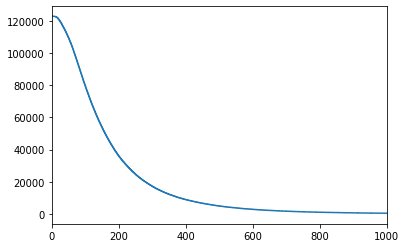

In [ ]:
# draw plot to see how is the recipe length distribution
# we can see that most are under 250 words in length

recipe_lens = [len(x.split(" ")) for x in string_recipes]
recipe_lens.sort(reverse=True)
plt.plot(recipe_lens, np.arange(len(string_recipes)))
plt.xlim([0, 1000])
plt.show()


In [96]:
# max length we want to use for recipe
MAX_NUM_WORDS = 250

# remove recipes over the max len


def filter_recipes_by_length(recipe_test):
    return len((recipe_test.split(" "))) <= MAX_NUM_WORDS


max_len_recipes = [
    recipe_text for recipe_text in filtered_string_recipes if filter_recipes_by_length(recipe_text)]


In [98]:
# * nltk processing
# we use lemmatization on the words, but chose not to use stemming because it caused weird results

from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('wordnet')

lm = WordNetLemmatizer()
ps = PorterStemmer()

for i in range(len(max_len_recipes)):
    sentence = max_len_recipes[i]
    sentence = lm.lemmatize(sentence)
    tokens = nltk.word_tokenize(sentence)
    nltk_data = " ".join(tokens)
    max_len_recipes[i] = nltk_data


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\inos1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\inos1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [122]:

# our stop word and vocabulary cap
STOP_SIGN = '<STOP>'
CAP = 10000

# tokenize the recipes on word_level, lowercase, and cap the number of words
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=CAP,
    char_level=False,
    filters='▪︎()',
    lower=True,
    split=' '
)

# add more stop signs to the tokenizer so that its not cut out later
tokenizer.fit_on_texts([STOP_SIGN]*3000)
tokenizer.fit_on_texts(max_len_recipes)

# tokenizer.get_config()


C:\Users\inos1\AppData\Local\Temp/ipykernel_123844/3254073397.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 30000])


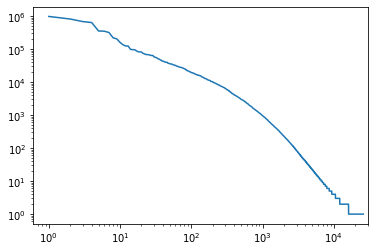

In [123]:
# plot word freq vs word indices
# use this plot to choose CAP
word_freq_sorted = sorted(
    tokenizer.word_counts.items(), key=lambda item: item[1], reverse=True)

word_ranks = [tokenizer.word_index[x[0]] for x in word_freq_sorted]

plt.loglog(word_ranks, [x[1] for x in word_freq_sorted])
plt.xlim([0, 30000])
plt.show()


In [124]:
# just to show how much we cut down because of this. our vocab size goes from 25k to 10k
print("vocab before shortening", len(tokenizer.word_index))


vocab before shortening 25882


In [115]:
# sort the words by their frequency and pick the top CAP number of words
sorted_by_word_count = sorted(
    tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
tokenizer.word_index = {}
i = 0
for word, count in sorted_by_word_count:
    if i == CAP:
        break
    tokenizer.word_index[word] = i + 1    # <= because tokenizer is 1 indexed
    i += 1


In [116]:
# actual vocab size (10k)
VOCABULARY_SIZE = len(tokenizer.word_index) + 1
print(VOCABULARY_SIZE)


10001


In [118]:
# tokenize the data
data_vectorized = tokenizer.texts_to_sequences(max_len_recipes)


In [119]:
# pad and truncate the data with stop words
data_padded = tf.keras.preprocessing.sequence.pad_sequences(
    data_vectorized,
    padding='post',
    truncating='post',
    maxlen=MAX_NUM_WORDS - 1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

data_padded = tf.keras.preprocessing.sequence.pad_sequences(
    data_padded,
    padding='post',
    truncating='post',
    maxlen=MAX_NUM_WORDS + 1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)


In [120]:
# os.makedirs('./saved_data')

# write the tokenizer and data into pickles
with open('./saved_data/tokenizer.pickle', 'wb+') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./saved_data/data_padded.pickle', 'wb+') as handle:
    pickle.dump(data_padded, handle, protocol=pickle.HIGHEST_PROTOCOL)
